In [212]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plot
import pycaret.classification as pycaret_classification

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import log_loss, f1_score, roc_curve



# Configurar o MLFLOW

In [166]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Lançamentos do Kobe Bryant'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/Users/rafael/dev/workspaces/infnet/pos-ai/machine-learning-engeneering/projeto-final-ml-eng/code/mlruns/1', creation_time=1712428469138, experiment_id='1', last_update_time=1712428469138, lifecycle_stage='active', name='Lançamentos do Kobe Bryant', tags={}>

# Preparação e análise do experimento

## Processa os dados de entrada

In [168]:
# Essas são as colunas que serão usadas nos experimentos a seguir
colunas = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
colunas_sem_alvo = ['lat','lon','minutes_remaining', 'period', 'playoffs', 'shot_distance']
coluna_alvo= 'shot_made_flag'

percentual_treinamento = 0.8

#Começa o experimento
with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados', nested=True):  
    dataframe_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    # Remove as linhas com campos nulos e copia o dataframe resultante selecionando apenas as colunas importantes para o experimento.
    dataframe_dev = dataframe_dev.dropna()
    dataframe_dev = dataframe_dev[colunas].copy()

    dataframe_dev.to_parquet('../data/processed/data_filtered.parquet')

    xtrain, xtest, ytrain, ytest = train_test_split(dataframe_dev[colunas_sem_alvo], 
                                                    dataframe_dev[coluna_alvo], 
                                                    train_size=percentual_treinamento, 
                                                    stratify=dataframe_dev[coluna_alvo]
                                                   )

    xtrain[coluna_alvo] = ytrain
    xtest[coluna_alvo] = ytest

    # Exporta bases de treino e teste
    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')
    
    mlflow.log_params({
        'percentual_teste': 1-percentual_treinamento,
        'colunas-selecionadas': colunas
    })
    mlflow.log_metrics({
        'quantidade_linhas_treino': xtrain.shape[0],
        'quantidade_linhas_teste': xtest.shape[0]
    })
    
mlflow_run = mlflow.active_run()


## Configura o pycaret

In [170]:
# configura pycaret
experiment = pycaret_classification.setup(
    data = xtrain, 
    target = coluna_alvo, 
    test_data = xtest, 
    normalize = True, 
    log_experiment = False
)

# Os modelos utilizados são regressão logística (lr) e árvore de decisão (dt)
modelos_utilizados = ['lr', 'dt']

list_models = experiment.compare_models(modelos_utilizados, n_select = 2)

list_models

,Description,Value
0,Session id,908
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5760,0.5978,0.4848,0.5654,0.5219,0.1451,0.1465,0.0150
dt,Decision Tree Classifier,0.5394,0.5208,0.5750,0.5158,0.5437,0.0814,0.0820,0.1640


[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=908, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=None, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        random_state=908, splitter='best')]

In [172]:
# plot com a validation curve "vc" e salva a imagem
experiment.plot_model(list_models[0], plot='vc', save = True)

# Cria função para plotar a calidation curve especificando o parametro
def plot_parameter_validation_curve(X, Y, param_name, grid_search,
                                    model, model_name, scoring,
                                    logx):
    print('Parameter:', param_name)
    print('GridSearch:', grid_search[param_name])
    print('Scoring:', scoring)
    plot.figure(figsize=(6,4))
    train_scores, test_scores = validation_curve(model,
                                                 X = X, 
                                                 y = Y, 
                                                 param_name=param_name, 
                                                 param_range= grid_search[param_name],
                                                 scoring=scoring,
                                                 cv=10,
                                                 n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plot.title("Curva Validação Modelo " + model_name)
    plot.xlabel(param_name)
    plot.ylabel("Score ("+scoring+")")
    if logx:
        plot.semilogx(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plot.semilogx(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                     color="navy", lw=2)
    else:
        plot.plot(grid_search[param_name], train_scores_mean,'-o', label="Treino",
                     color="darkorange", lw=2)
        plot.plot(grid_search[param_name], test_scores_mean,'-o', label="Validação-Cruzada",
                 color="navy", lw=2)
    plot.fill_between(grid_search[param_name], train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=2)
    plot.fill_between(grid_search[param_name], test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=2)
    plot.legend(loc='best')
    plot.grid(True)
    
    image = plot.gcf()
    image_name = 'validation_curve' + '_' + model_name + '_' + param_name + '.png'
    image.savefig(image_name, dpi=100)
    plot.show()
    return image_name


## Registra regressão logistica

In [173]:
yhat_test = experiment.predict_model(list_models[0])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5807,0.6023,0.4992,0.5695,0.5320,0.1552,0.1563


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


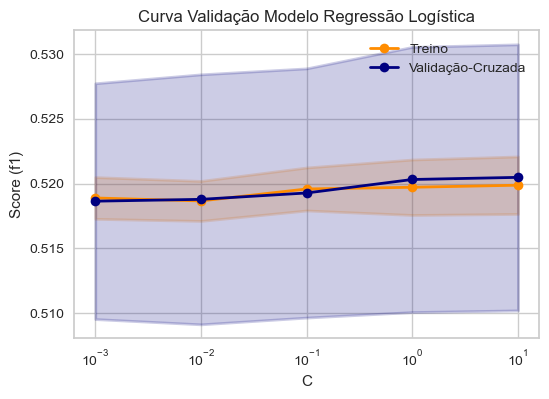

In [176]:
image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]}, list_models[0], 'Regressão Logística', 'f1', logx=True)

mlflow.log_artifact(image_name, run_id=mlflow_run.info.run_id)

os.remove(image_name)

mlflow.log_metrics({
'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

# Registra árvore de decisão

In [178]:
yhat_test = experiment.predict_model(list_models[1])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5386,0.5173,0.5932,0.5146,0.5511,0.0813,0.0822


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


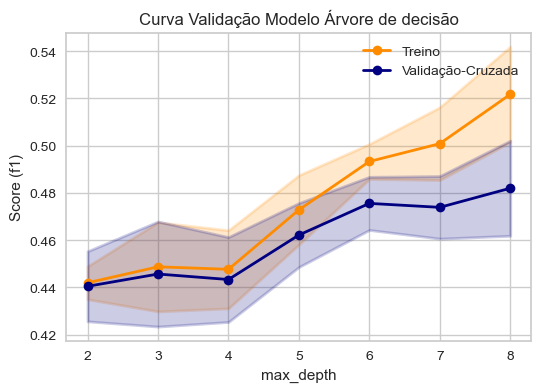

In [180]:
image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]}, list_models[1], 'Árvore de decisão', 'f1', logx=False)

mlflow.log_artifact(image_name)

os.remove(image_name)

mlflow.log_metrics({
'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

# Treinamento do modelo

In [196]:
mlflow.end_run()

,Description,Value
0,Session id,8443
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5760,0.5978,0.4848,0.5654,0.5219,0.1451,0.1465,0.0120
dt,Decision Tree Classifier,0.5360,0.5167,0.5710,0.5127,0.5402,0.0748,0.0752,0.0160


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5807,0.6023,0.4992,0.5695,0.5320,0.1552,0.1563


Parameter: C
GridSearch: [0.001, 0.01, 0.1, 1, 10]
Scoring: f1


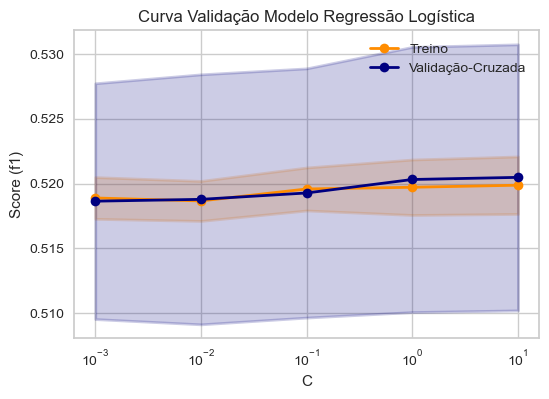

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5428,0.5222,0.5947,0.5185,0.5540,0.0894,0.0903


Parameter: max_depth
GridSearch: [2, 3, 4, 5, 6, 7, 8]
Scoring: f1


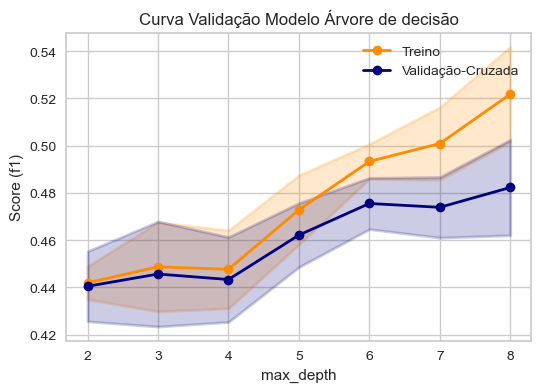

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5576,0.5827,0.5290,0.5374,0.5332,0.1128,0.1128
1,0.5607,0.5956,0.5239,0.5413,0.5325,0.1184,0.1184
2,0.5662,0.5837,0.5342,0.5469,0.5405,0.1298,0.1299
3,0.5841,0.6013,0.5355,0.5685,0.5515,0.1644,0.1647
4,0.5847,0.5979,0.5445,0.5680,0.5560,0.1663,0.1664
5,0.5724,0.6110,0.5316,0.5545,0.5428,0.1415,0.1416
6,0.5779,0.6078,0.5452,0.5589,0.5520,0.1532,0.1532
7,0.5632,0.5896,0.5530,0.5411,0.5470,0.1253,0.1253
8,0.5937,0.6076,0.5788,0.5736,0.5762,0.1860,0.1861


Fitting 10 folds for each of 4 candidates, totalling 40 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5719,0.6023,0.5441,0.5524,0.5482,0.1414,0.1414


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_kobe' already exists. Creating a new version of this model...
Created version '4' of model 'modelo_kobe'.


In [210]:
registered_model_name = 'modelo_kobe'
nexamples = 5
model_version = -1

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    # configura pycaret
    experiment = pycaret_classification.setup(
        data = xtrain, 
        target = coluna_alvo, 
        test_data = xtest, 
        normalize = True, 
        log_experiment = False
    )

    # Os modelos utilizados são regressão logística (lr) e árvore de decisão (dt)
    modelos_utilizados = ['lr', 'dt']

    list_models = experiment.compare_models(modelos_utilizados, n_select = 2)

    list_models
    
    # Regressão Logística
    yhat_test = experiment.predict_model(list_models[0])
    lr_image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'C', {'C': [0.001, 0.01, 0.1, 1, 10]}, list_models[0], 'Regressão Logística', 'f1', logx=True)

    mlflow.log_artifact(lr_image_name)

    os.remove(lr_image_name)

    mlflow.log_metrics({
    'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    # Árvore de decisão
    yhat_test = experiment.predict_model(list_models[1])
    
    dt_image_name = plot_parameter_validation_curve(xtrain.drop(coluna_alvo, axis=1), ytrain, 'max_depth', {'max_depth': [2, 3, 4, 5, 6, 7, 8]}, list_models[1], 'Árvore de decisão', 'f1', logx=False)

    mlflow.log_artifact(dt_image_name)

    os.remove(dt_image_name)

    mlflow.log_metrics({
    'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    # Finaliza o melhor modelo ( Regressão Logística)
    tune_model = experiment.tune_model(list_models[0], optimize = 'f1', search_library = 'scikit-learn', search_algorithm = 'random',  n_iter = 4)
    
    yhat_test = experiment.predict_model(tune_model)
    mlflow.log_metrics({
    'final_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
    'final_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })
    
    final_model = experiment.finalize_model(tune_model)

    # EXPORTA PARA LOG E REGISTRO DO MODELO FINAL

    registered_model_name = 'modelo_kobe'
    nexamples = 5

    experiment.save_model(final_model, f'./{registered_model_name}') 

    # Carrega novamente o pipeline + bestmodel
    model_pipe = experiment.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow

    model_features = list(xtrain.drop(coluna_alvo, axis=1).columns)
    inf_signature = infer_signature(xtrain[model_features], model_pipe.predict(xtrain.drop(coluna_alvo, axis=1)))
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name=registered_model_name,
        version=model_version, # Verificar com usuario qual versao
        alias="staging"
    )



    
    

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5807,0.6023,0.4992,0.5695,0.5320,0.1552,0.1563


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5428,0.5222,0.5947,0.5185,0.5540,0.0894,0.0903


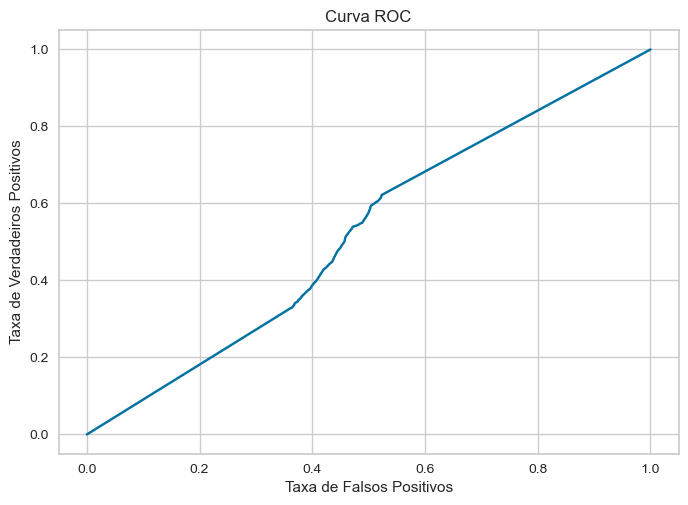

In [244]:
yhat_test = experiment.predict_model(list_models[0], raw_score=True)
fpr, tpr, thr = roc_curve(yhat_test.shot_made_flag, yhat_test.prediction_score_1)
plot.plot(fpr, tpr, label='Regressão Logística')

yhat_test = experiment.predict_model(list_models[1], raw_score=True)
fpr, tpr, thr = roc_curve(yhat_test.shot_made_flag, yhat_test.prediction_score_1)
plot.plot(fpr, tpr, label='Árvore de Decisão')


plot.xlabel('Taxa de Falsos Positivos')
plot.ylabel('Taxa de Verdadeiros Positivos')
plot.title('Curva ROC')

plot.show()




In [264]:
# Finaliza o melhor modelo ( Regressão Logística)
tune_model = experiment.tune_model(list_models[0], optimize = 'f1', search_library = 'scikit-learn', search_algorithm = 'random',  n_iter = 4)

yhat_test = experiment.predict_model(tune_model)
mlflow.log_metrics({
'final_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
'final_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
})

final_model = experiment.finalize_model(tune_model)

# EXPORTA PARA LOG E REGISTRO DO MODELO FINAL

registered_model_name = 'modelo_kobe'
nexamples = 5

experiment.save_model(final_model, f'./{registered_model_name}') 

# Carrega novamente o pipeline + bestmodel
model_pipe = experiment.load_model(f'./{registered_model_name}')
# Assinatura do Modelo Inferida pelo MLFlow

model_features = list(xtrain.drop(coluna_alvo, axis=1).columns)
inf_signature = infer_signature(xtrain[model_features], model_pipe.predict_proba(xtrain.drop(coluna_alvo, axis=1)))
# Exemplo de entrada para o MLmodel
input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
    sk_model=model_pipe,
    artifact_path="sklearn-model",
    registered_model_name=registered_model_name,
    signature = inf_signature,
    input_example = input_example,
    pyfunc_predict_fn = 'predict_proba'
)
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name)[-1].version
# Registrar o modelo como staging
client.set_registered_model_alias(
    name=registered_model_name,
    version=model_version, # Verificar com usuario qual versao
    alias="staging"
)

    
    

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5576,0.5827,0.5290,0.5374,0.5332,0.1128,0.1128
1,0.5607,0.5956,0.5239,0.5413,0.5325,0.1184,0.1184
2,0.5662,0.5837,0.5342,0.5469,0.5405,0.1298,0.1299
3,0.5841,0.6013,0.5355,0.5685,0.5515,0.1644,0.1647
4,0.5847,0.5979,0.5445,0.5680,0.5560,0.1663,0.1664
5,0.5724,0.6110,0.5316,0.5545,0.5428,0.1415,0.1416
6,0.5779,0.6078,0.5452,0.5589,0.5520,0.1532,0.1532
7,0.5632,0.5896,0.5530,0.5411,0.5470,0.1253,0.1253
8,0.5937,0.6076,0.5788,0.5736,0.5762,0.1860,0.1861


Fitting 10 folds for each of 4 candidates, totalling 40 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5719,0.6023,0.5441,0.5524,0.5482,0.1414,0.1414


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'modelo_kobe' already exists. Creating a new version of this model...
Created version '8' of model 'modelo_kobe'.


In [194]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['lat', 'lon', 'minutes_remaining',
                                             'period', 'playoffs',
                                             'shot_distance'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean',
                                                              verbose='deprecated'))),
                ('categorical_imp...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('actual_estimator',
                 LogisticRegression(C=9.154, class_weight='balanced',
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2', random_state=908,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# Reset do estilo de cores do matplotlib 

# Detalhamento dos passos do projeto


# Experimento de Classificação de Lançamentos

# Leitura dos Dados de Classificação de Lançamentos 